This notebook has the purpose of comparing tidal ellipses calculated by the model to other data sources.

#Loading and Preparing the Files

The following cells in this section will load, mask, rotate and unstagger the model output data. 

In [3]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import datetime
import pandas as pd

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

In [4]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

In [5]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 8)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

runname1 = '{}_{}_{}_Central'.format(t_o, t_f, 'h')
runname2 = '{}_{}_{}_East'.format(t_o, t_f, 'h')

#Only importing M2 parameters
cols=np.arange(0,4)

df1 = pd.read_csv(runname1+'.csv', usecols=cols) 
df2 = pd.read_csv(runname2+'.csv', usecols=cols)

cen = df1.as_matrix()
east = df2.as_matrix()
cen.shape

(39, 4)

In [6]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 18)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

runname1 = '{}_{}_{}_Central_depav'.format(t_o, t_f, '15')
runname2 = '{}_{}_{}_East_depav'.format(t_o, t_f, '15')

#Only importing M2 parameters
cols=np.arange(0,1)

df1 = pd.read_csv(runname1+'.csv', index_col=False) 
df2 = pd.read_csv(runname2+'.csv', index_col=False)

cen_av = df1.as_matrix()
east_av = df2.as_matrix()
print cols, cen_av

[0] [[  1.69210962e-01   1.39461195e-02   1.29780537e+02   2.18193169e+01
    7.11329719e-02   4.38327592e-03   1.35020433e+02]]


The locations of the nodes are stored in a dictionary in research_VENUS.py

Slice in order to compare, the min and max depth values for each location is determine by the comparison source.

#Fits

The following cells will calculate the cell-centered model output velocities' tidal parameters.

#Comparisons
##Depth Averaged at VENUS nodes 

Mark Halverson's values:

In [7]:
majc = 0.179
minorc = 0.05
incc = 109

#CODAR values
majc_cod = 0.113
minorc_cod = 0.08
incc_cod = 127

maje = 0.262
minore = -0.04
ince = 124

maje_cod = 0.138
minore_cod = -0.037
ince_cod = 133

The nodes were depth averaged between 35 - 290 m at the Central node and 20 - 160 m at the East node. I have done the same with the model output. Note that the node values wer averaged about 10-11 months where are the model output values were averages over 6 1/2 months (Nov 24, 2014 to June 8, 2015).

In [8]:
print "Central   Major-Axis   Minor-Axis     Angle"
print "           (m/s)      (m/s)     (deg ccw E)"  
print ' Model      {0:.2f}       {1:.2f}      {2:.0f}   '.format( 
         cen_av[0,0], cen_av[0,1], cen_av[0,2]) 
print ' Nodes      {0:.2f}       {1:.2f}      {2:.0f}   '.format(
         majc, minorc, incc)
#print ' CODAR      {0:.2f}       {1:.2f}      {2:.0f}   '.format(
#         majc_cod, minorc_cod, incc_cod)


print "East   Major-Axis   Minor-Axis     Angle"
print "           (m/s)      (m/s)     (deg ccw E)"  
print ' Model      {0:.2f}       {1:.2f}      {2:.0f}   '.format( 
         east_av[0,0], east_av[0,1], east_av[0,2]) 
print ' Nodes      {0:.2f}       {1:.2f}      {2:.0f}   '.format(
         maje, minore, ince)
#print ' CODAR      {0:.2f}       {1:.2f}      {2:.0f}   '.format(
#         maje_cod, minore_cod, ince_cod)


Central   Major-Axis   Minor-Axis     Angle
           (m/s)      (m/s)     (deg ccw E)
 Model      0.17       0.01      130   
 Nodes      0.18       0.05      109   
East   Major-Axis   Minor-Axis     Angle
           (m/s)      (m/s)     (deg ccw E)
 Model      0.30       -0.02      138   
 Nodes      0.26       -0.04      124   


The CODAR region evaluates only the currents in the first meter of the water column. These values are compared with the 0.5 m depth model outputs.

In [9]:
print "Central   Major-Axis   Minor-Axis     Angle"
print "           (m/s)      (m/s)     (deg ccw E)"  
print ' Model      {0:.2f}       {1:.2f}      {2:.0f}   '.format( 
         cen[0,1], cen[0,2], cen[0,3]) 
print ' CODAR      {0:.2f}       {1:.2f}      {2:.0f}   '.format(
         majc_cod, minorc_cod, incc_cod)


print "East   Major-Axis   Minor-Axis     Angle"
print "           (m/s)      (m/s)     (deg ccw E)"  
print ' Model      {0:.2f}       {1:.2f}      {2:.0f}   '.format( 
         east[0,1], east[0,2], east[0,3]) 
print ' CODAR      {0:.2f}       {1:.2f}      {2:.0f}   '.format(
         maje_cod, minore_cod, ince_cod)

Central   Major-Axis   Minor-Axis     Angle
           (m/s)      (m/s)     (deg ccw E)
 Model      0.20       -0.07      137   
 CODAR      0.11       0.08      127   
East   Major-Axis   Minor-Axis     Angle
           (m/s)      (m/s)     (deg ccw E)
 Model      0.40       -0.18      127   
 CODAR      0.14       -0.04      133   


##Plotting ellipses

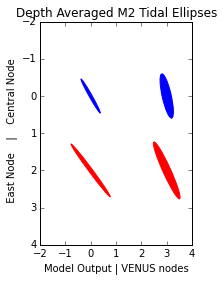

In [10]:
fig = plt.figure()
ax = fig.add_subplot(121)
scale = 7


if cen_av[0,1] > 0:
    thec = 'b'
else:
    thec = 'r'
ells = Ellipse(xy=(0,0), width=scale*cen_av[0,0], 
                    height=scale*cen_av[0,1], angle=-cen_av[0,2],
                    color=thec)
ax.add_artist(ells)
ells.set_facecolor(thec)

if minorc > 0:
    thec = 'b'
else:
    thec = 'r'
ells = Ellipse(xy=(3,0), width=scale*majc, 
                    height=scale*minorc, angle=-incc,
                    color=thec)
ax.add_artist(ells)
ells.set_facecolor(thec)
    
    
if east_av[0,1] > 0:
    thec = 'b'
else:
    thec = 'r'
ells = Ellipse(xy=(0,2), width=scale*east_av[0,0], 
                    height=scale*east_av[0,1], angle=-east_av[0,2],
                    color=thec)
ax.add_artist(ells)
ells.set_facecolor(thec)

if minore > 0:
    thec = 'b'
else:
    thec = 'r'
ells = Ellipse(xy=(3,2), width=scale*maje, 
                    height=scale*minore, angle=-ince,
                    color=thec)
ax.add_artist(ells)
ells.set_facecolor(thec)
ax.set_ylim(-2,4)
ax.invert_yaxis()
ax.set_xlim(-2,4)
ax.set_title('Depth Averaged M2 Tidal Ellipses')
ax.set_ylabel('  East Node    |    Central Node')
ax.set_xlabel('Model Output | VENUS nodes')

In [11]:
font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 20}

red is clockwise


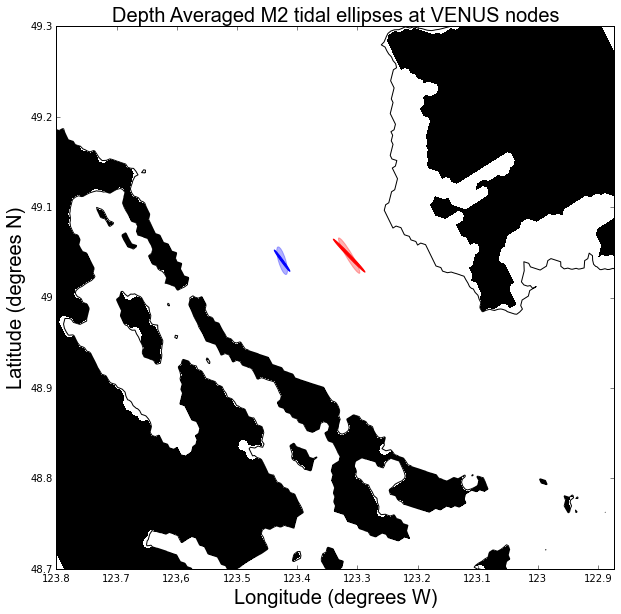

In [12]:
phi=29
k = np.zeros((898,398)); m = np.zeros((898,398))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 90

#Inverted i and j to match code
sites = research_VENUS.SITES
ic = sites['VENUS']['Central']['i']
ie = sites['VENUS']['East']['i']
jc = sites['VENUS']['Central']['j']
je = sites['VENUS']['East']['j']


for i in np.arange(je-ex,jc+ex):
    for j in np.arange(ic-ex,ie+ex):
        k[i,j] = i*np.cos(phi*np.pi/180.)+j*np.sin(phi*np.pi/180.)
        m[i,j] = -i*np.sin(phi*np.pi/180.)+j*np.cos(phi*np.pi/180.) 
scale = 40
interval = 4
depth=0
#Making the ellipse for the Central node
if cen_av[0,1] > 0:
    thec = 'b'
else:
    thec = 'r'
ellsc = Ellipse(xy=(m[jc,ic],k[jc,ic]), width=scale*cen_av[0,0], 
                    height=scale*cen_av[0,1], angle=cen_av[0,2],
                    color=thec)
ax.add_artist(ellsc)
ellsc.set_facecolor(thec)

if minorc > 0:
    thec = [0,0,1, 0.3]
else:
    thec = [1,0,0, 0.3]
ellsc_n = Ellipse(xy=(m[jc,ic],k[jc,ic]), width=scale*majc, 
                    height=scale*minorc, angle=incc,
                    color=thec)
ax.add_artist(ellsc_n)
ellsc_n.set_facecolor(thec)

#Making the ellipse for the East node
if east_av[0,1] > 0:
    thec = 'b'
else:
    thec = 'r'
ellse = Ellipse(xy=(m[je,ie],k[je,ie]), width=scale*east_av[0,0], 
                    height=scale*east_av[0,1], angle=east_av[0,2],
                    color=thec)
ax.add_artist(ellse)
ellse.set_facecolor(thec)

if minore > 0:
    thec = [0,0,1, 0.3]
else:
    thec = [1,0,0, 0.3]
ellse_n = Ellipse(xy=(m[je,ie],k[je,ie]), width=scale*maje, 
                    height=scale*minore, angle=ince,
                    color=thec)
ax.add_artist(ellse_n)
ellse_n.set_facecolor(thec)



# y-axis in k, but labelled in latitude
ax.set_ylim(480,490)
slope = (lats[jc,ic]-lats[je,ic])/(k[jc,ic]-k[je,ic])
mylist = (k[je,ic]+(np.arange(48.7, 49.35, 0.1)-
                           lats[je,ic])/slope).tolist()
labels = ['48.7','48.8', '48.9', '49', '49.1', '49.2', '49.3']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)', **font)
# x-axis in m, but labelled in longitude
ax.set_xlim(100,120)
slope = (lons[je,ie]-lons[je,ic])/(m[je,ie]-m[je,ic])
mylist = (m[je,ic]+(np.arange(-123.8,-122.85,0.1)-
                        lons[je,ic])/slope).tolist()
labels = ['123.8','123.7','123,6','123.5','123.4','123.3', '123.2', '123.1', '123','122.9']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)', **font)


# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[je-ex:jc+ex,ic-ex:ie+ex],k[je-ex:jc+ex,ic-ex:ie+ex],
            bathy.data[je-ex:jc+ex,ic-ex:ie+ex],contour_interval,colors='black')
ax.contour(m[je-ex:jc+ex,ic-ex:ie+ex],k[je-ex:jc+ex,ic-ex:ie+ex],
            bathy.data[je-ex:jc+ex,ic-ex:ie+ex],[5],colors='black')
ax.set_title('Depth Averaged M2 tidal ellipses at VENUS nodes', **font)

print "red is clockwise"


##Surface comparisons with CODAR

red is clockwise


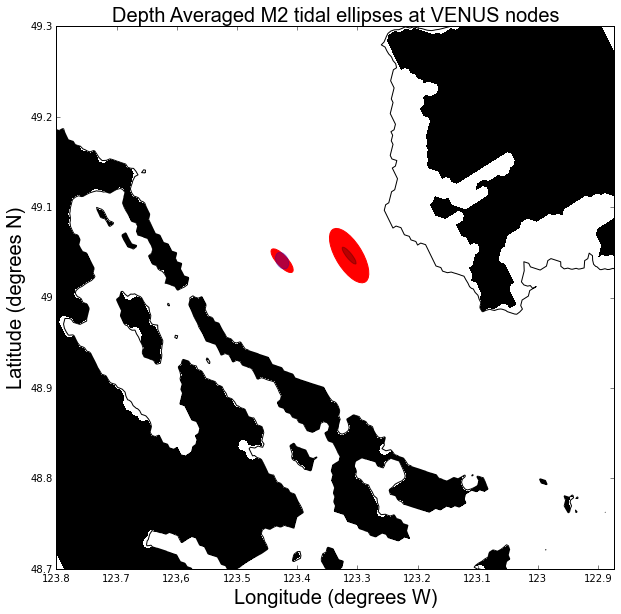

In [13]:
phi=29
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 90

#Inverted i and j to match code
sites = research_VENUS.SITES
ic = sites['VENUS']['Central']['i']
ie = sites['VENUS']['East']['i']
jc = sites['VENUS']['Central']['j']
je = sites['VENUS']['East']['j']


for i in np.arange(je-ex,jc+ex):
    for j in np.arange(ic-ex,ie+ex):
        k[i,j] = i*np.cos(phi*np.pi/180.)+j*np.sin(phi*np.pi/180.)
        m[i,j] = -i*np.sin(phi*np.pi/180.)+j*np.cos(phi*np.pi/180.) 
scale = 40
interval = 4
depth=0
#Making the ellipse for the Central node
if cen[0,2] > 0:
    thec = 'b'
else:
    thec = 'r'
ellsc = Ellipse(xy=(m[jc,ic],k[jc,ic]), width=scale*cen[0,1], 
                    height=scale*cen[0,2], angle=cen[0,3],
                    color=thec)
ax.add_artist(ellsc)
ellsc.set_facecolor(thec)

if minorc_cod > 0:
    thec = [0,0,0.8, 0.3]
else:
    thec = [0.8,0,0, 0.3]
ellsc_c = Ellipse(xy=(m[jc,ic],k[jc,ic]), width=scale*majc_cod, 
                    height=scale*minorc_cod, angle=incc_cod,
                    color=thec)
ax.add_artist(ellsc_c)
ellsc_c.set_facecolor(thec)

#Making the ellipse for the East node
if east[0,2] > 0:
    thec = 'b'
else:
    thec = 'r'
ellse = Ellipse(xy=(m[je,ie],k[je,ie]), width=scale*east[0,1], 
                    height=scale*east[0,2], angle=east[0,3],
                    color=thec)
ax.add_artist(ellse)
ellse.set_facecolor(thec)

if minore_cod > 0:
    thec = [0,0,0.8, 0.3]
else:
    thec = [0.1,0,0, 0.3]
ellse_c = Ellipse(xy=(m[je,ie],k[je,ie]), width=scale*maje_cod, 
                    height=scale*minore_cod, angle=ince_cod,
                    color=thec)
ax.add_artist(ellse_c)
ellse_c.set_facecolor(thec)



# y-axis in k, but labelled in latitude
ax.set_ylim(480,490)
slope = (lats[jc,ic]-lats[je,ic])/(k[jc,ic]-k[je,ic])
mylist = (k[je,ic]+(np.arange(48.7, 49.35, 0.1)-
                           lats[je,ic])/slope).tolist()
labels = ['48.7','48.8', '48.9', '49', '49.1', '49.2', '49.3']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)', **font)
# x-axis in m, but labelled in longitude
ax.set_xlim(100,120)
slope = (lons[je,ie]-lons[je,ic])/(m[je,ie]-m[je,ic])
mylist = (m[je,ic]+(np.arange(-123.8,-122.85,0.1)-
                        lons[je,ic])/slope).tolist()
labels = ['123.8','123.7','123,6','123.5','123.4','123.3', '123.2', '123.1', '123','122.9']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)', **font)


# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[je-ex:jc+ex,ic-ex:ie+ex],k[je-ex:jc+ex,ic-ex:ie+ex],
            bathy.data[je-ex:jc+ex,ic-ex:ie+ex],contour_interval,colors='black')
ax.contour(m[je-ex:jc+ex,ic-ex:ie+ex],k[je-ex:jc+ex,ic-ex:ie+ex],
            bathy.data[je-ex:jc+ex,ic-ex:ie+ex],[5],colors='black')
ax.set_title('Depth Averaged M2 tidal ellipses at VENUS nodes', **font)

print "red is clockwise"

##Depth profile comparison

For this comparison I will use ADCP data compiled by Rich Pawlovich and Mark Halverson at the ONC VENUS nodes.

In [112]:
eastobs = np.loadtxt('/ocean/mhalvers/research/adcp/east_ADCP_M2_ellipse_params.txt', skiprows=2, unpack=True)
central = np.loadtxt('/ocean/mhalvers/research/adcp/central_ADCP_M2_ellipse_params.txt', skiprows=2, unpack=True)

In [113]:
i = np.where(np.logical_and(cen[:,0] > central[0,1], cen[:,0] < central[0,-1]))
j = np.where(np.logical_and(east[:,0] > eastobs[0,1], east[:,0] < eastobs[0,-1]))

###Central node

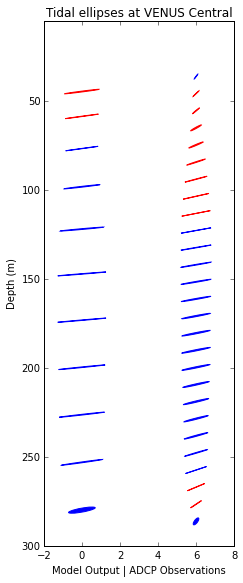

In [16]:
fig = plt.figure(figsize=(7.5,9.4))
ax = fig.add_subplot(121)
scale = 20
interval = 2

for ind, dep in zip(i[0],cen[i[0],0]):
    if cen[ind,2] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*cen[ind,1], 
                        height=scale*cen[ind,2], angle=cen[ind,3],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for ind, dep in zip(np.arange(0,(len(central[0,:])-1), interval), central[0,:][::interval]):
    if central[2,ind] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*central[1,ind]/100, 
                        height=scale*central[2,ind]/100, angle=central[3,ind],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(5,300)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS Central')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Model Output | ADCP Observations')

### East node

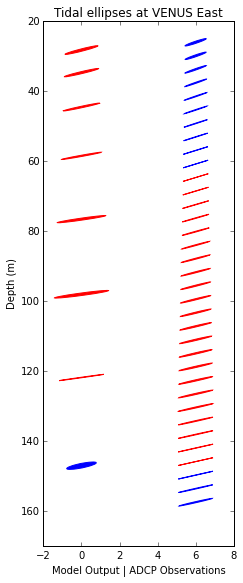

In [17]:
fig = plt.figure(figsize=(7.5,9.4))
ax = fig.add_subplot(121)
scale = 10
interval = 2

for ind, dep in zip(j[0],east[j[0],0]):
    if east[ind,2] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*east[ind,1], 
                        height=scale*east[ind,2], angle=east[ind,3],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for ind, dep in zip(np.arange(0,(len(eastobs[0,:])-1), interval), eastobs[0,:][::interval]):
    if eastobs[2,ind] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*eastobs[1,ind]/100, 
                        height=scale*eastobs[2,ind]/100, angle=eastobs[3,ind],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(20,170)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS East')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Model Output | ADCP Observations')

...looks like I am comparing apples and oranges...

In [114]:

count = np.arange(0,2)
parameter = ['major-axis', 'minor-axis', 'inclination']
unit = ['m/s','m/s','deg']
central[1:3,:] = central[1:2,:]/100
eastobs[1:3,:] = eastobs[1:2,:]/100


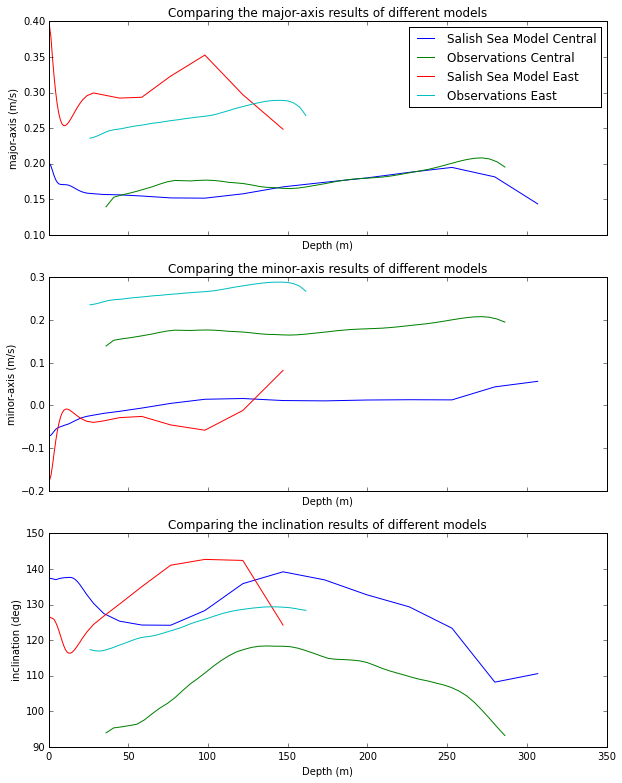

In [115]:
fig, (ax0, ax1, ax2)= plt.subplots(3,1,figsize=(10,13), sharex=True)

for ax , k, par, u in zip([ax0, ax1, ax2], np.arange(1,4), parameter, unit):
    ax.plot(cen[:-4,0],cen[:-4,k], '-', label='Salish Sea Model Central')
    ax.plot(central[0,:], central[k,:], '-', label='Observations Central')
    ax.plot(east[:-10,0],east[:-10,k], '-', label='Salish Sea Model East')
    ax.plot(eastobs[0,:], eastobs[k,:], '-', label='Observations East')

    ax.set_title('Comparing the {} results of different models'.format(par))
    ax.set_xlabel('Depth (m)')
    ax.set_ylabel('{} ({})'.format(par,u))
ax0.legend()